In [1]:
import pandas

### PMF Algorithm

In [2]:
import numpy as np
from numpy import linalg as LA

class PMF:
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat
        self.epsilon = epsilon
        self._lambda = _lambda
        self.momentum = momentum
        self.maxepoch = maxepoch
        self.num_batches = num_batches
        self.batch_size = batch_size
        
        self.w_C = None
        self.w_I = None

        self.err_train = []
        self.err_val = []
        
    def fit(self, train_vec, val_vec):   
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:,2])
        
        pairs_tr = train_vec.shape[0]
        pairs_va = val_vec.shape[0]
        
        # 1-p-i, 2-m-c
        num_inv = int(max(np.amax(train_vec[:,0]), np.amax(val_vec[:,0]))) + 1
        num_com = int(max(np.amax(train_vec[:,1]), np.amax(val_vec[:,1]))) + 1

        incremental = False
        if ((not incremental) or (self.w_C is None)):
            # initialize
            self.epoch = 0
            self.w_C = 0.1 * np.random.randn(num_com, self.num_feat)
            self.w_I = 0.1 * np.random.randn(num_inv, self.num_feat)
            
            self.w_C_inc = np.zeros((num_com, self.num_feat))
            self.w_I_inc = np.zeros((num_inv, self.num_feat))
        
        
        while self.epoch < self.maxepoch:
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)

            # Batch update
            for batch in range(self.num_batches):
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                batch_idx = np.mod(np.arange(self.batch_size * batch,
                                             self.batch_size * (batch+1)),
                                   shuffled_order.shape[0])

                batch_invID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_comID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_I[batch_invID,:], 
                                                self.w_C[batch_comID,:]),
                                axis=1) # mean_inv subtracted

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_C = 2 * np.multiply(rawErr[:, np.newaxis], self.w_I[batch_invID,:]) \
                        + self._lambda * self.w_C[batch_comID,:]
                Ix_I = 2 * np.multiply(rawErr[:, np.newaxis], self.w_C[batch_comID,:]) \
                        + self._lambda * self.w_I[batch_invID,:]
            
                dw_C = np.zeros((num_com, self.num_feat))
                dw_I = np.zeros((num_inv, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_C[batch_comID[i],:] += Ix_C[i,:]
                    dw_I[batch_invID[i],:] += Ix_I[i,:]


                # Update with momentum
                self.w_C_inc = self.momentum * self.w_C_inc + self.epsilon * dw_C / self.batch_size
                self.w_I_inc = self.momentum * self.w_I_inc + self.epsilon * dw_I / self.batch_size


                self.w_C = self.w_C - self.w_C_inc
                self.w_I = self.w_I - self.w_I_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_I[np.array(train_vec[:,0], dtype='int32'),:],
                                                    self.w_C[np.array(train_vec[:,1], dtype='int32'),:]),
                                        axis=1) # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = LA.norm(rawErr) ** 2 \
                            + 0.5*self._lambda*(LA.norm(self.w_I) ** 2 + LA.norm(self.w_C) ** 2)

                    self.err_train.append(np.sqrt(obj/pairs_tr))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_I[np.array(val_vec[:,0], dtype='int32'),:],
                                                    self.w_C[np.array(val_vec[:,1], dtype='int32'),:]),
                                        axis=1) # mean_inv subtracted
                    rawErr = pred_out - val_vec[:, 2] + self.mean_inv
                    self.err_val.append(LA.norm(rawErr)/np.sqrt(pairs_va))

                # Print info
#                 if batch == self.num_batches - 1:
#                    print 'Training RMSE: %f, Test RMSE %f' % (self.err_train[-1], self.err_val[-1])

    def predict(self, invID): 
        return np.dot(self.w_C, self.w_I[invID,:]) + self.mean_inv
        
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

In [3]:
import numpy as np

def topK(model, test_vec, k=10):
	inv_lst = np.unique(test_vec[:, 0])
	pred = {}
	for inv in inv_lst:
		if pred.get(inv, None) is None:
			pred[inv] = np.argsort(model.predict(inv))[-k:]

	intersection_cnt = {}
	for i in range(test_vec.shape[0]):
		if test_vec[i, 1] in pred[test_vec[i, 0]]:
			intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
	invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

	precision_acc = 0.0
	recall_acc = 0.0
	for inv in inv_lst:
		precision_acc += intersection_cnt.get(inv, 0)/float(k)
		recall_acc += intersection_cnt.get(inv, 0)/float(invPairs_cnt[inv])
#     print inv_lst

	return precision_acc/len(inv_lst), recall_acc/len(inv_lst)

In [4]:
def get_class(cluster):
    # for cluster
    # get class a from data
    a_class = df_description.loc[kcluster[cluster]]['asin'].values.tolist()
    table = data.loc[data['asin'].isin(a_class)][['asin','reviewer','star_rating']]
    # form a table of class a subset
    table['rating'] = table['star_rating'].values.tolist() #change to number
    asin = {v: k for k, v in enumerate(table['asin'].unique())}
    reviewer = {v: k for k, v in enumerate(table['reviewer'].unique())}
    temp = table.replace({'asin':asin,'reviewer':reviewer})
    temp.drop(['star_rating'],axis=1,inplace=True)
    matrix_r = temp[temp["rating"]!=0]
    matrix = matrix_r.reindex(columns=['reviewer','asin','rating'])
    # matrix.head()
    from sklearn.model_selection import train_test_split
    train_data, test_data = train_test_split(matrix, test_size=0.25)
    #Create two user-item matrices, one for training and another for testing
    train_list = list(train_data.itertuples(index=False, name=None))
    test_list = list(test_data.itertuples(index=False, name=None))
    train_array = np.asarray(train_list)
    test_array = np.asarray(test_list)

    # Train PMF
    model = PMF()
    fit = model.fit(train_array,test_array)

    result = []
    for key,value in reviewer.items():
        for k,v in asin.items():
            result.append((key,k,model.predict(value)[v]))
    rMSE = [len(asin),np.mean(model.err_train)]
    return result, rMSE

In [5]:
#Alternative
def trainPMF(matrix,dic_reviewer,dic_asin):
    from sklearn.model_selection import train_test_split
    train_data, test_data = train_test_split(matrix, test_size=0.25)
    #Create two user-item matrices, one for training and another for testing
    train_list = list(train_data.itertuples(index=False, name=None))
    test_list = list(test_data.itertuples(index=False, name=None))
    train_array = np.asarray(train_list)
    test_array = np.asarray(test_list)

    # Train PMF
    model = PMF()
    fit = model.fit(train_array,test_array)

    # Result Stored in List of tuple
    result = []
    for i in range(len(dic_reviewer)):
        for j in range(len(dic_asin)):
            result.append((dic_reviewer[i],dic_asin[j],model.predict(i)[j]))
    return result, [len(dic_asin),np.mean(model.err_train)]

### In Category Training Result

In [6]:
# Load classification
import pandas
# original data
df_description = pandas.read_csv("description_update.csv")

data = pandas.read_csv("no_outlier_data.csv")

import pickle
with open('data.pickle', 'rb') as handle:
    kcluster = pickle.load(handle)

In [7]:
def get_rMSE(cluster):
    # for cluster
    # get class a from data
    a_class = df_description.loc[kcluster[cluster]]['asin'].values.tolist()
    table = data.loc[data['asin'].isin(a_class)][['asin','reviewer','star_rating']]
    # form a table of class a subset
    table['rating'] = table['star_rating'].values.tolist() #change to number
    asin = {v: k for k, v in enumerate(table['asin'].unique())}
    reviewer = {v: k for k, v in enumerate(table['reviewer'].unique())}
    temp = table.replace({'asin':asin,'reviewer':reviewer})
    temp.drop(['star_rating'],axis=1,inplace=True)
    matrix_r = temp[temp["rating"]!=0]
    matrix = matrix_r.reindex(columns=['reviewer','asin','rating'])
    # matrix.head()
    from sklearn.model_selection import train_test_split
    train_data, test_data = train_test_split(matrix, test_size=0.25)
    #Create two user-item matrices, one for training and another for testing
    train_list = list(train_data.itertuples(index=False, name=None))
    test_list = list(test_data.itertuples(index=False, name=None))
    train_array = np.asarray(train_list)
    test_array = np.asarray(test_list)

    # Train PMF
    model = PMF()
    fit = model.fit(train_array,test_array)

    return [len(asin),np.mean(model.err_train)]

In [ ]:
output = dict()
in_rMSE = dict()
# for index in range(0,10):
#     output[index] = get_class(index)
for index in kcluster.keys():
    output[index],in_rMSE[index] = get_class(index)
    print in_rMSE.items()[index]

In [25]:
import csv
with open('in_category_result.csv','wb') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['reviewer','asin','rating'])
    for key in output.keys():
        for row in output[key]:
            csv_out.writerow(row)

------------------
### Cross category Classification and Result

In [26]:
category = pandas.read_csv("df_101.csv")

In [27]:
def get_crossclass():
    #######cross-category
    # change to tupple with non-zero
    category_copy = category.copy()
    category_copy.columns=["cluster"]+range(category.columns[1:].size)
    category_copy.index=range(category.index.size)
    category_copy['cluster'] = range(category.index.size)
    dic_category = [i for i in category.index]
    dic_reviewer = [i for i in category.columns[1:]]

    temp = pandas.melt(category_copy,id_vars=["cluster"])

    temp.head()
    matrix_r = temp[temp["value"]!=0]
    matrix_r.columns=['cluster','reviewer','mean_rating']
    # matrix_r.head()
    matrix = matrix_r.reindex(columns=['reviewer','cluster','mean_rating'])
    # matrix.head()
    from sklearn.model_selection import train_test_split
    train_data, test_data = train_test_split(matrix, test_size=0.25)
    #Create two user-item matrices, one for training and another for testing
    train_list = list(train_data.itertuples(index=False, name=None))
    test_list = list(test_data.itertuples(index=False, name=None))
    train_array = np.asarray(train_list)
    test_array = np.asarray(test_list)

    return trainPMF(matrix,dic_reviewer,dic_category)

In [461]:
def write_csv(result):
    import csv
    with open('crosscategory_result.csv','wb') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['reviewer','cluster','rating'])
        for row in result:
            csv_out.writerow(row)

In [32]:
result, rMSE = get_crossclass()

In [33]:
rMSE

[100, 1.3497206155074557]

In [315]:
write_csv(result)

### Evaluation for Accuracy and Coverage
--------
Visualization rMSE & scaling time

In [44]:
def observNo(cluster):
    # for cluster
    # get class a from data
    a_class = df_description.loc[kcluster[cluster]]['asin'].values.tolist()
    table = data.loc[data['asin'].isin(a_class)][['asin','reviewer','star_rating']]
    # form a table of class a subset
    table['rating'] = table['star_rating'].values.tolist() #change to number
    asin = {v: k for k, v in enumerate(table['asin'].unique())}
    reviewer = {v: k for k, v in enumerate(table['reviewer'].unique())}
    temp = table.replace({'asin':asin,'reviewer':reviewer})
    temp.drop(['star_rating'],axis=1,inplace=True)
    matrix_r = temp[temp["rating"]!=0]
    matrix = matrix_r.reindex(columns=['reviewer','asin','rating'])
    return matrix.shape[0]

In [45]:
# for i in 
observ=[]
for index in kcluster.keys():
    observ.append(observNo(index))

In [46]:
Run = pandas.read_csv("CatRunTime.csv")
runTime = Run['Time'].tolist()

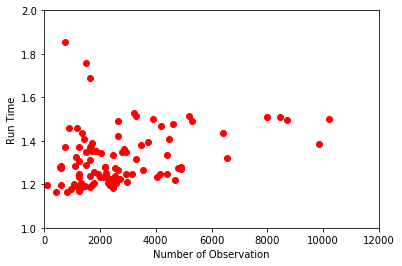

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(len(runTime)):
    plt.plot(observ[i], runTime[i], 'ro')
plt.xlabel("Number of Observation")
plt.ylabel("Run Time")
plt.xlim([0,12000])
plt.ylim([1,2])
plt.show()

Most of the category data had 1000 to 4000 observation ratings, their running time ranged from 1.2s to 1.5s.
This running time was relatively fast and consistence across different category data.
Notice that for larger number of observations, the run time increased but still kept within 1.6s per data set.

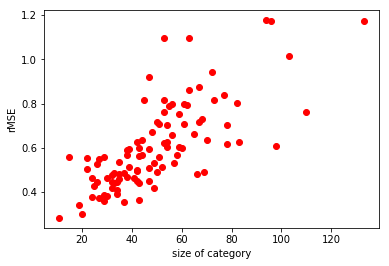

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

for value in in_rMSE.values():
    plt.plot(value[0], value[1], 'ro')
plt.xlabel("size of category")
plt.ylabel("rMSE")
# plt.xlim([0,6])
plt.show()


rMSE Vs. Observed Rating

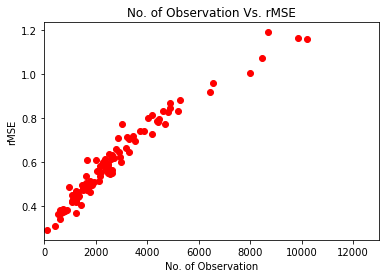

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 0
for value in in_rMSE.values():
    
    plt.plot(observ[i], value[1], 'ro')
    i+=1
plt.title('No. of Observation Vs. rMSE')
plt.xlabel("No. of Observation")
plt.ylabel("rMSE")
plt.xlim([0,13000])
plt.show()

In [ ]:
rMSE_df = pandas.DataFrame(in_rMSE.values(), columns = {"size","rMSE"})

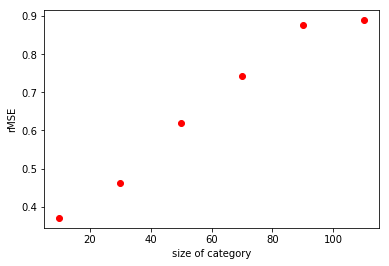

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
xaxis = range(0,6)
for x in xaxis:
    left = x*20
    right = (x+1)*20
    xrMSE = rMSE_df.loc[rMSE_df['size'].between(left, right),'rMSE'].mean()
    plt.plot(right - 10, xrMSE, 'ro')
# for value in in_rMSE.values():
#     plt.plot(value[0], value[1], 'ro')
plt.xlabel("size of category")
plt.ylabel("rMSE")
# plt.xlim([0,6])
plt.show()

### Scalability

In [112]:
import timeit
def get_time(cluster):
    # for cluster
    # get class a from data
    a_class = df_description.loc[kcluster[cluster]]['asin'].values.tolist()
    table = data.loc[data['asin'].isin(a_class)][['asin','reviewer','star_rating']]
    # form a table of class a subset
    table['rating'] = table['star_rating'].values.tolist() #change to number
    asin = {v: k for k, v in enumerate(table['asin'].unique())}
    reviewer = {v: k for k, v in enumerate(table['reviewer'].unique())}
    temp = table.replace({'asin':asin,'reviewer':reviewer})
    temp.drop(['star_rating'],axis=1,inplace=True)
    matrix_r = temp[temp["rating"]!=0]
    matrix = matrix_r.reindex(columns=['reviewer','asin','rating'])
    # matrix.head()
    from sklearn.model_selection import train_test_split
    train_data, test_data = train_test_split(matrix, test_size=0.25)
    #Create two user-item matrices, one for training and another for testing
    train_list = list(train_data.itertuples(index=False, name=None))
    test_list = list(test_data.itertuples(index=False, name=None))
    train_array = np.asarray(train_list)
    test_array = np.asarray(test_list)

    # Train PMF
    start = timeit.default_timer()
    model = PMF()
    fit = model.fit(train_array,test_array)
    stop = timeit.default_timer()
    return [len(asin),stop-start]

In [ ]:
time = {}
for index in kcluster.keys():
    time[index] = get_time(index)
    print time.items()[index]

In [116]:
time_df = pandas.DataFrame(time.values(), columns = {"size","time"})

In [149]:
time_df['time'].mean()

1.3277255296707153

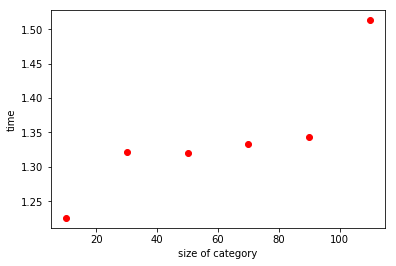

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
xaxis = range(0,6)
for x in xaxis:
    left = x*20
    right = (x+1)*20
    xtime = time_df.loc[time_df['size'].between(left, right),'time'].mean()
    plt.plot(right - 10, xtime, 'ro')
# for value in in_rMSE.values():
#     plt.plot(value[0], value[1], 'ro')
plt.xlabel("size of category")
plt.ylabel("time")
# plt.xlim([0,6])
plt.show()



### Coverage

In [23]:
def get_input_array(cluster):
# get class a from data
    a_class = df_description.loc[kcluster[cluster]]['asin'].values.tolist()
    table = data.loc[data['asin'].isin(a_class)][['asin','reviewer','star_rating']]
    # form a table of class a subset
    table['rating'] = table['star_rating'].values.tolist() #change to number
    asin = {v: k for k, v in enumerate(table['asin'].unique())}
    reviewer = {v: k for k, v in enumerate(table['reviewer'].unique())}
    temp = table.replace({'asin':asin,'reviewer':reviewer})
    temp.drop(['star_rating'],axis=1,inplace=True)
    matrix_r = temp[temp["rating"]!=0]
    matrix = matrix_r.reindex(columns=['reviewer','asin','rating'])
    
    matrix.head()
    from sklearn.model_selection import train_test_split
    train_data, test_data = train_test_split(matrix, test_size=0.25)
    #Create two user-item matrices, one for training and another for testing
    train_list = list(train_data.itertuples(index=False, name=None))
    test_list = list(test_data.itertuples(index=False, name=None))
    train_array = np.asarray(train_list)
    test_array = np.asarray(test_list)
    return train_array,test_array,asin,reviewer

In [24]:
# for every cluster 55 , 0 , 32
test55,train55,asin55,reviewer55 = get_input_array(55)
test0,train0,asin0,reviewer0 = get_input_array(0)
test32,train32,asin32,reviewer32= get_input_array(32)


In [25]:
# Train Every Model
model55 = PMF()
fit55 = model55.fit(train55,test55)
model0 = PMF()
fit0 = model0.fit(train0,test0)
model32 = PMF()
fit32 = model32.fit(train32,test32)

In [29]:
def result(model,asin,reviewer):   
    result = []
    for key,value in reviewer.items():
        for k,v in asin.items():
            result.append((key,k,model.predict(value)[v]))

    result_df = pandas.DataFrame(result)
    result_df.columns ={"asin","rating","reviewer"}
    return result_df
def Coverage(result_df,k):
    # result_df
    unique_reviewer = result_df['reviewer'].unique().tolist()
    unique_item = result_df['asin'].unique().tolist()
    TopK = []
    for rev in range(len(unique_reviewer)): 
    # for rev in range(3):
    # list of top 10 items id recommends for user i
        TopK += result_df.loc[result_df['reviewer']==unique_reviewer[rev]].sort_values('rating',ascending = False)[:k]['asin'].tolist()
    #     print rev
    return float(len(set(TopK)))/float(len(unique_item))

In [28]:
result55 = result(model55,asin55,reviewer55)
result0 = result(model0,asin0,reviewer0)
result32 = result(model32,asin32,reviewer32)

In [34]:
k = [2,4,6,8,10]
coverage55 = []
for i in k:
    c = Coverage(result55,i)
    coverage55.append(c)

In [36]:
coverage0 = []
coverage32 = []
for i in k:
    c = Coverage(result0,i)
    coverage0.append(c)
for i in k:
    c = Coverage(result32,i)
    coverage32.append(c)

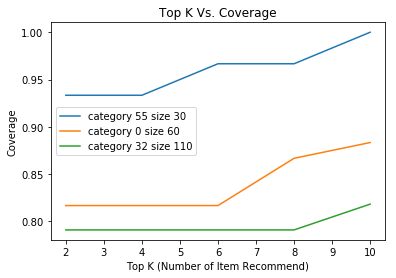

In [40]:
import matplotlib.pyplot as plt
# %matplotlib inline
line_55, = plt.plot(k,coverage55,label = 'category 55 size 30')
line_0, = plt.plot(k,coverage0,label = 'category 0 size 60')
line_32, = plt.plot(k,coverage32,label = 'category 32 size 110')

# for value in in_rMSE.values():
#     plt.plot(value[0], value[1], 'ro')
plt.xlabel("Top K (Number of Item Recommend)")
plt.ylabel("Coverage")
plt.title("Top K Vs. Coverage")
# plt.ylim([0.5,1.2])
plt.legend(handles=[line_55, line_0,line_32])
plt.show()

In [151]:
category = [55,0,32]
coverage = []
for i in category:
    coverage.append(get_coverage(i))

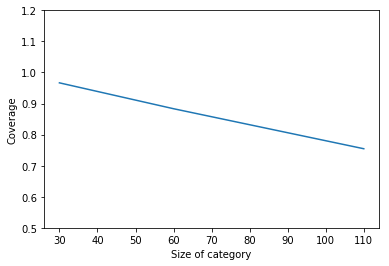

In [152]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.plot(size,coverage)
# for value in in_rMSE.values():
#     plt.plot(value[0], value[1], 'ro')
plt.xlabel("Size of category")
plt.ylabel("Coverage")
plt.ylim([0.5,1.2])
plt.show()



### Hyper Parameter Tuning Regularization 
Regualrization Training

In [ ]:
# Train Every Model
model55 = PMF()
fit55 = model55.fit(train55,test55)
model0 = PMF()
fit0 = model0.fit(train0,test0)
model32 = PMF()
fit32 = model32.fit(train32,test32)


In [ ]:
rMSE = {}
for i in regular:
    # Train PMF
    model = PMF(_lambda = i )
    fit = model.fit(train_array,test_array)
    rMSE[i] = (np.mean(model.err_train))
return rMSE

In [100]:
# select category 0 size 60, 32 size 110, 55 size 30
def regularization_train(model,train_array,test_array,regular):#L2
    rMSE = {}
    for i in regular:
        # Train PMF
        model = PMF(_lambda = i )
        fit = model.fit(train_array,test_array)
        rMSE[i] = (np.mean(model.err_train))
    return rMSE


In [98]:
cat55=[model55,train55,test55]
cat0=[model0,train0,test0]
cat32=[model32,train32,test32]
category = [cat55,cat0,cat32]

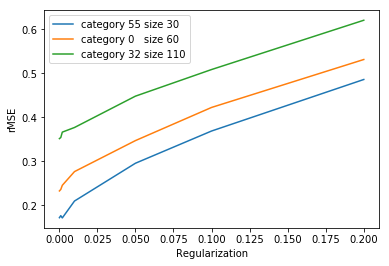

In [102]:
size = [30,60,110]
lambda_value = [0.2,0.1,0.05,0.01,0.002,0.001,0.0001] # according to paper 
regular_result = {}
for i in range(0,3):
    regular_result[size[i]] = regularization_train(category[i][0],category[i][1],category[i][2],lambda_value)
lists = sorted(regular_result[30].items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
line30, = plt.plot(x, y,label = 'category 55 size 30')
lists = sorted(regular_result[60].items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
line60, = plt.plot(x, y,label = 'category 0   size 60')
lists = sorted(regular_result[110].items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
line110, = plt.plot(x, y, label = 'category 32 size 110')
plt.xlabel("Regularization")
plt.ylabel("rMSE")
plt.legend(handles=[line30, line60,line110])
plt.show()

Number of Features

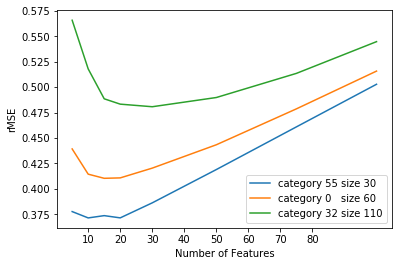

In [106]:
lists = sorted(feature_result[30].items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
line30, = plt.plot(x, y,label = 'category 55 size 30')
lists = sorted(feature_result[60].items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
line60, = plt.plot(x, y,label = 'category 0   size 60')
lists = sorted(feature_result[110].items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
line110, = plt.plot(x, y, label = 'category 32 size 110')
plt.xlabel("Number of Features")
plt.ylabel("rMSE")
plt.legend(handles=[line30, line60,line110])
plt.xticks([10,20,30,40,50,60,70,80])
plt.show()